In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.data import read_merged
from seminartools.data import read_inflation

# 1. Read data

In [3]:
df = read_merged().reset_index()
df

c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:173: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").apply(lambda x: (1 + x).prod() - 1)  # quarterly return
c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:409: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").mean()  # Mean interest rate


,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.00000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.00000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.00000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
...,...,...,...,...,...,...,...,...,...,...,...
2166,Italy,2023-01-01,0.003938,0.552944,3.000000,8.3,-0.02041,-0.585458,0.002037,0.007418,0.043183
2167,Canada,2023-01-01,0.006080,0.610026,4.500000,5.4,-0.02041,-0.585458,0.002037,0.007418,0.043183
2168,Sweden,2023-01-01,0.014955,0.656897,2.833333,7.8,-0.02041,-0.585458,0.002037,0.007418,0.043183
2169,Korea,2023-01-01,0.010538,0.329875,3.500000,3.2,-0.02041,-0.585458,0.002037,0.007418,0.043183


In [4]:
from scipy.signal import gaussian

In [5]:
from seminartools.models.utils import get_stats
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel
from seminartools.time_series_split import ExpandingWindowSplit
from seminartools.models.cov_bhm_model import CovBHMModel

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats = get_stats(
    [
        ("ar", lambda: ARMAXModel(max_p=2, max_q=0)),
        ("random_effects_1_lag", lambda: RandomEffectsModel()),
        ("random_effects_2_lag", lambda: RandomEffectsModel(lags = 2)),
        ("distance_1_lag", lambda: DistanceModel()),
        ("distance_2_lag", lambda: DistanceModel(lags = 2)),
        ("cov_bhm", lambda: CovBHMModel(lags=1)),
    ],
    df,
    ExpandingWindowSplit(
        start_date = "2010-01-01",
        num_splits = 1,
    ),
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)
stats


c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message w

,mse,mae,r2,mz_intercept,mz_slope,mz_r2,mz_wald_test_statistic,p-value
ar,0.000061,0.005502,0.257362,0.000052,0.948273,0.259118,1.209008,0.29892072644883366
random_effects_1_lag,0.000078,0.006256,0.054794,0.001788,0.650952,0.082928,15.599579,2.1233858770786635e-07
distance_1_lag,0.000078,0.006184,0.053576,0.002148,0.610889,0.094356,22.897108,1.8762708840153056e-10
cov_bhm,0.000080,0.006289,0.037426,0.002211,0.590172,0.080213,23.654400,9.095002706076482e-11
random_effects_2_lag,0.000081,0.006366,0.020148,0.002721,0.548113,0.064335,23.943246,6.912711181853428e-11
distance_2_lag,0.000082,0.006407,0.007019,0.002959,0.513548,0.071548,35.237518,1.6029753009077053e-15


In [11]:
subdf = df.query("date <= '2010-01-01'")
model_ar = ARMAXModel(max_p=2, max_q=0)
model_ar.fit(df)
model_re = RandomEffectsModel(lags = 2)
model_re.fit(df)
model_distance = DistanceModel(lags = 2)
model_distance.fit(df)
model_cov_bhm = CovBHMModel(lags=2)
model_cov_bhm.fit(df)

Creating regression coefficients: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Creating regression coefficients: 100%|██████████| 2/2 [00:00<00:00, 135.47it/s]


# Compare coefficients

In [22]:
import arviz as az
country = "France"
country_idx = model_cov_bhm.countries.tolist().index(country)
params_cov_bhm = az.summary(model_cov_bhm.trace.posterior,round_to = 6)
params_cov_bhm.index
out = {
    "const": params_cov_bhm.loc[f"intercepts[{country_idx}]", "mean"]
}
for lag in range(1, model_cov_bhm.lags + 1):
    out[f"L{lag}"] = params_cov_bhm.loc[f"regression_coefficients_inflation_lag_{lag}[{country_idx}]", "mean"]
params_cov_bhm = pd.Series(out)
params_cov_bhm

const   -0.180248
L1       0.252407
L2       0.159208
dtype: float64

In [23]:
import arviz as az
from tqdm import tqdm

def get_params(country):
    params_ar = model_ar.models[country].params
    out = {
        "const": params_ar["const"],
    }
    for lag in range(1, len(model_ar.models[country].params) - 1):
        out[f"L{lag}"] = params_ar[f"ar.L{lag}"]
    params_ar = pd.Series(out)
    params_re = az.summary(model_re.results.posterior, round_to = 6)
    out = {
        "const": params_re.loc["Intercept", "mean"] + params_re.loc[f"1|country[{country}]", "mean"]
    }
    for i in range(1, model_re.lags + 1):
        out[f"L{i}"] = params_re.loc[f"inflation_lag_{i}|country[{country}]", "mean"]
    params_re = pd.Series(out)
    country_idx = model_distance.countries.tolist().index(country)
    params_distance = az.summary(model_distance.trace.posterior, round_to = 6)
    params_distance.index
    out = {
        "const": params_distance.loc[f"intercepts[{country_idx}]", "mean"]
    }
    for lag in range(1, model_distance.lags + 1):
        out[f"L{lag}"] = params_distance.loc[f"regression_coefficients_inflation_lag_{lag}[{country_idx}]", "mean"]

    params_distance = pd.Series(out)

    country_idx = model_cov_bhm.countries.tolist().index(country)
    params_cov_bhm = az.summary(model_cov_bhm.trace.posterior,round_to = 6)
    params_cov_bhm.index
    out = {
        "const": params_cov_bhm.loc[f"intercepts[{country_idx}]", "mean"]
    }
    for lag in range(1, model_cov_bhm.lags + 1):
        out[f"L{lag}"] = params_cov_bhm.loc[f"regression_coefficients_inflation_lag_{lag}[{country_idx}]", "mean"]
    params_cov_bhm = pd.Series(out)


    params = pd.concat([
        params_ar,
        params_re,
        params_distance,
        params_cov_bhm
    ], axis=1, keys=["AR", "RE-BHM", "DB-BHM", "COV-BHM"])
    return params

params = pd.concat([
    get_params(country)
    for country in tqdm(model_distance.countries)
], keys=model_distance.countries, axis=0)
params

100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


AR    RE-BHM    DB-BHM   COV-BHM
Japan          const -0.330119 -0.215571 -0.213243 -0.213234
               L1     0.118223  0.032418  0.027186  0.026729
               L2     0.491085  0.427588  0.455266  0.455550
Canada         const  0.206456  0.056022  0.055249  0.055901
               L1     0.661475  0.559497  0.585068  0.581261
               L2          NaN  0.104596  0.090664  0.095224
United States  const  0.239861  0.095019  0.093725  0.093962
               L1     0.607452  0.594870  0.621540  0.620611
               L2          NaN -0.019877 -0.035414 -0.036569
Australia      const  0.410967  0.108467  0.105235  0.104426
               L1     0.395985  0.389942  0.393731  0.394587
               L2     0.334892  0.323693  0.332178  0.331868
New Zealand    const -0.041423 -0.034976 -0.033909 -0.033821
               L1     0.395130  0.345963  0.366417  0.368839
               L2     0.155159  0.144113  0.147814  0.149775
Switzerland    const -0.563361 -0.481633 -0.409708 -0.510987
               L1     0.168116  0.033270  0.096007 -0.007221
               L2     0.369313  0.236432  0.288210  0.276305
Italy          const -0.188280 -0.076127 -0.076371 -0.071580
               L1     0.379221  0.358082  0.364805  0.379148
               L2     0.210371  0.192210  0.224970  0.216062
France         const -0.340533 -0.191723 -0.182517 -0.180248
               L1     0.281251  0.227042  0.211883  0.252407
               L2          NaN  0.132921  0.207470  0.159208
Portugal       const -0.177446 -0.114012 -0.111341 -0.113981
               L1    -0.104508 -0.104760 -0.106880 -0.103747
               L2     0.478272  0.449910  0.480869  0.479065
Spain          const -0.153850 -0.069037 -0.068794 -0.066661
               L1    -0.142170 -0.150396 -0.144288 -0.142066
               L2     0.605141  0.577691  0.608739  0.608316
Sweden         const -0.184349 -0.067054 -0.058018 -0.053561
               L1     0.225690  0.245203  0.247489  0.243165
               L2     0.491901  0.435135  0.470391  0.488112
Denmark        const -0.228356 -0.142313 -0.142800 -0.143091
               L1     0.417665  0.393146  0.436734  0.444673
               L2          NaN -0.035556 -0.061077 -0.064474
United Kingdom const -0.233270 -0.190613 -0.175754 -0.187580
               L1    -0.114030 -0.093885 -0.039531 -0.104664
               L2     0.264790  0.223876  0.245998  0.287627
Germany        const -0.208878 -0.122778 -0.126241 -0.120810
               L1     0.388598  0.417192  0.514268  0.493878
               L2          NaN -0.027267 -0.095803 -0.064192
Netherlands    const -0.158088 -0.114583 -0.107135 -0.115393
               L1     0.436523  0.402323  0.428488  0.443082
               L2    -0.187616 -0.159952 -0.154214 -0.189178
Norway         const -0.129210 -0.125070 -0.126980 -0.128410
               L1    -0.000534 -0.003663  0.004623 -0.003324
               L2          NaN -0.024486 -0.023165 -0.028021
Belgium        const -0.142292 -0.063974 -0.089904 -0.063667
               L1     0.465026  0.401960  0.424021  0.448008
               L2          NaN  0.055033  0.021185  0.034069
Korea          const -0.092459 -0.055457 -0.055982 -0.054642
               L1     0.091647  0.095484  0.103143  0.108831
               L2     0.156743  0.131177  0.154049  0.152987
South Africa   const  0.749296  0.567871  0.633905  0.622819
               L1     0.279400  0.186404  0.182043  0.187777
               L2          NaN -0.029021 -0.068382 -0.064556
Türkiye        const  1.948558  1.405777  1.637263  1.627510
               L1     0.067755  0.118519  0.076725  0.077532
               L2          NaN  0.122319  0.082767  0.084993

In [8]:
import seaborn as sns

#cm = sns.light_palette("pink", as_cmap=True)
# get coolwarm cmap
cm = sns.color_palette("coolwarm", as_cmap=True)
params.style.background_gradient(cmap=cm)



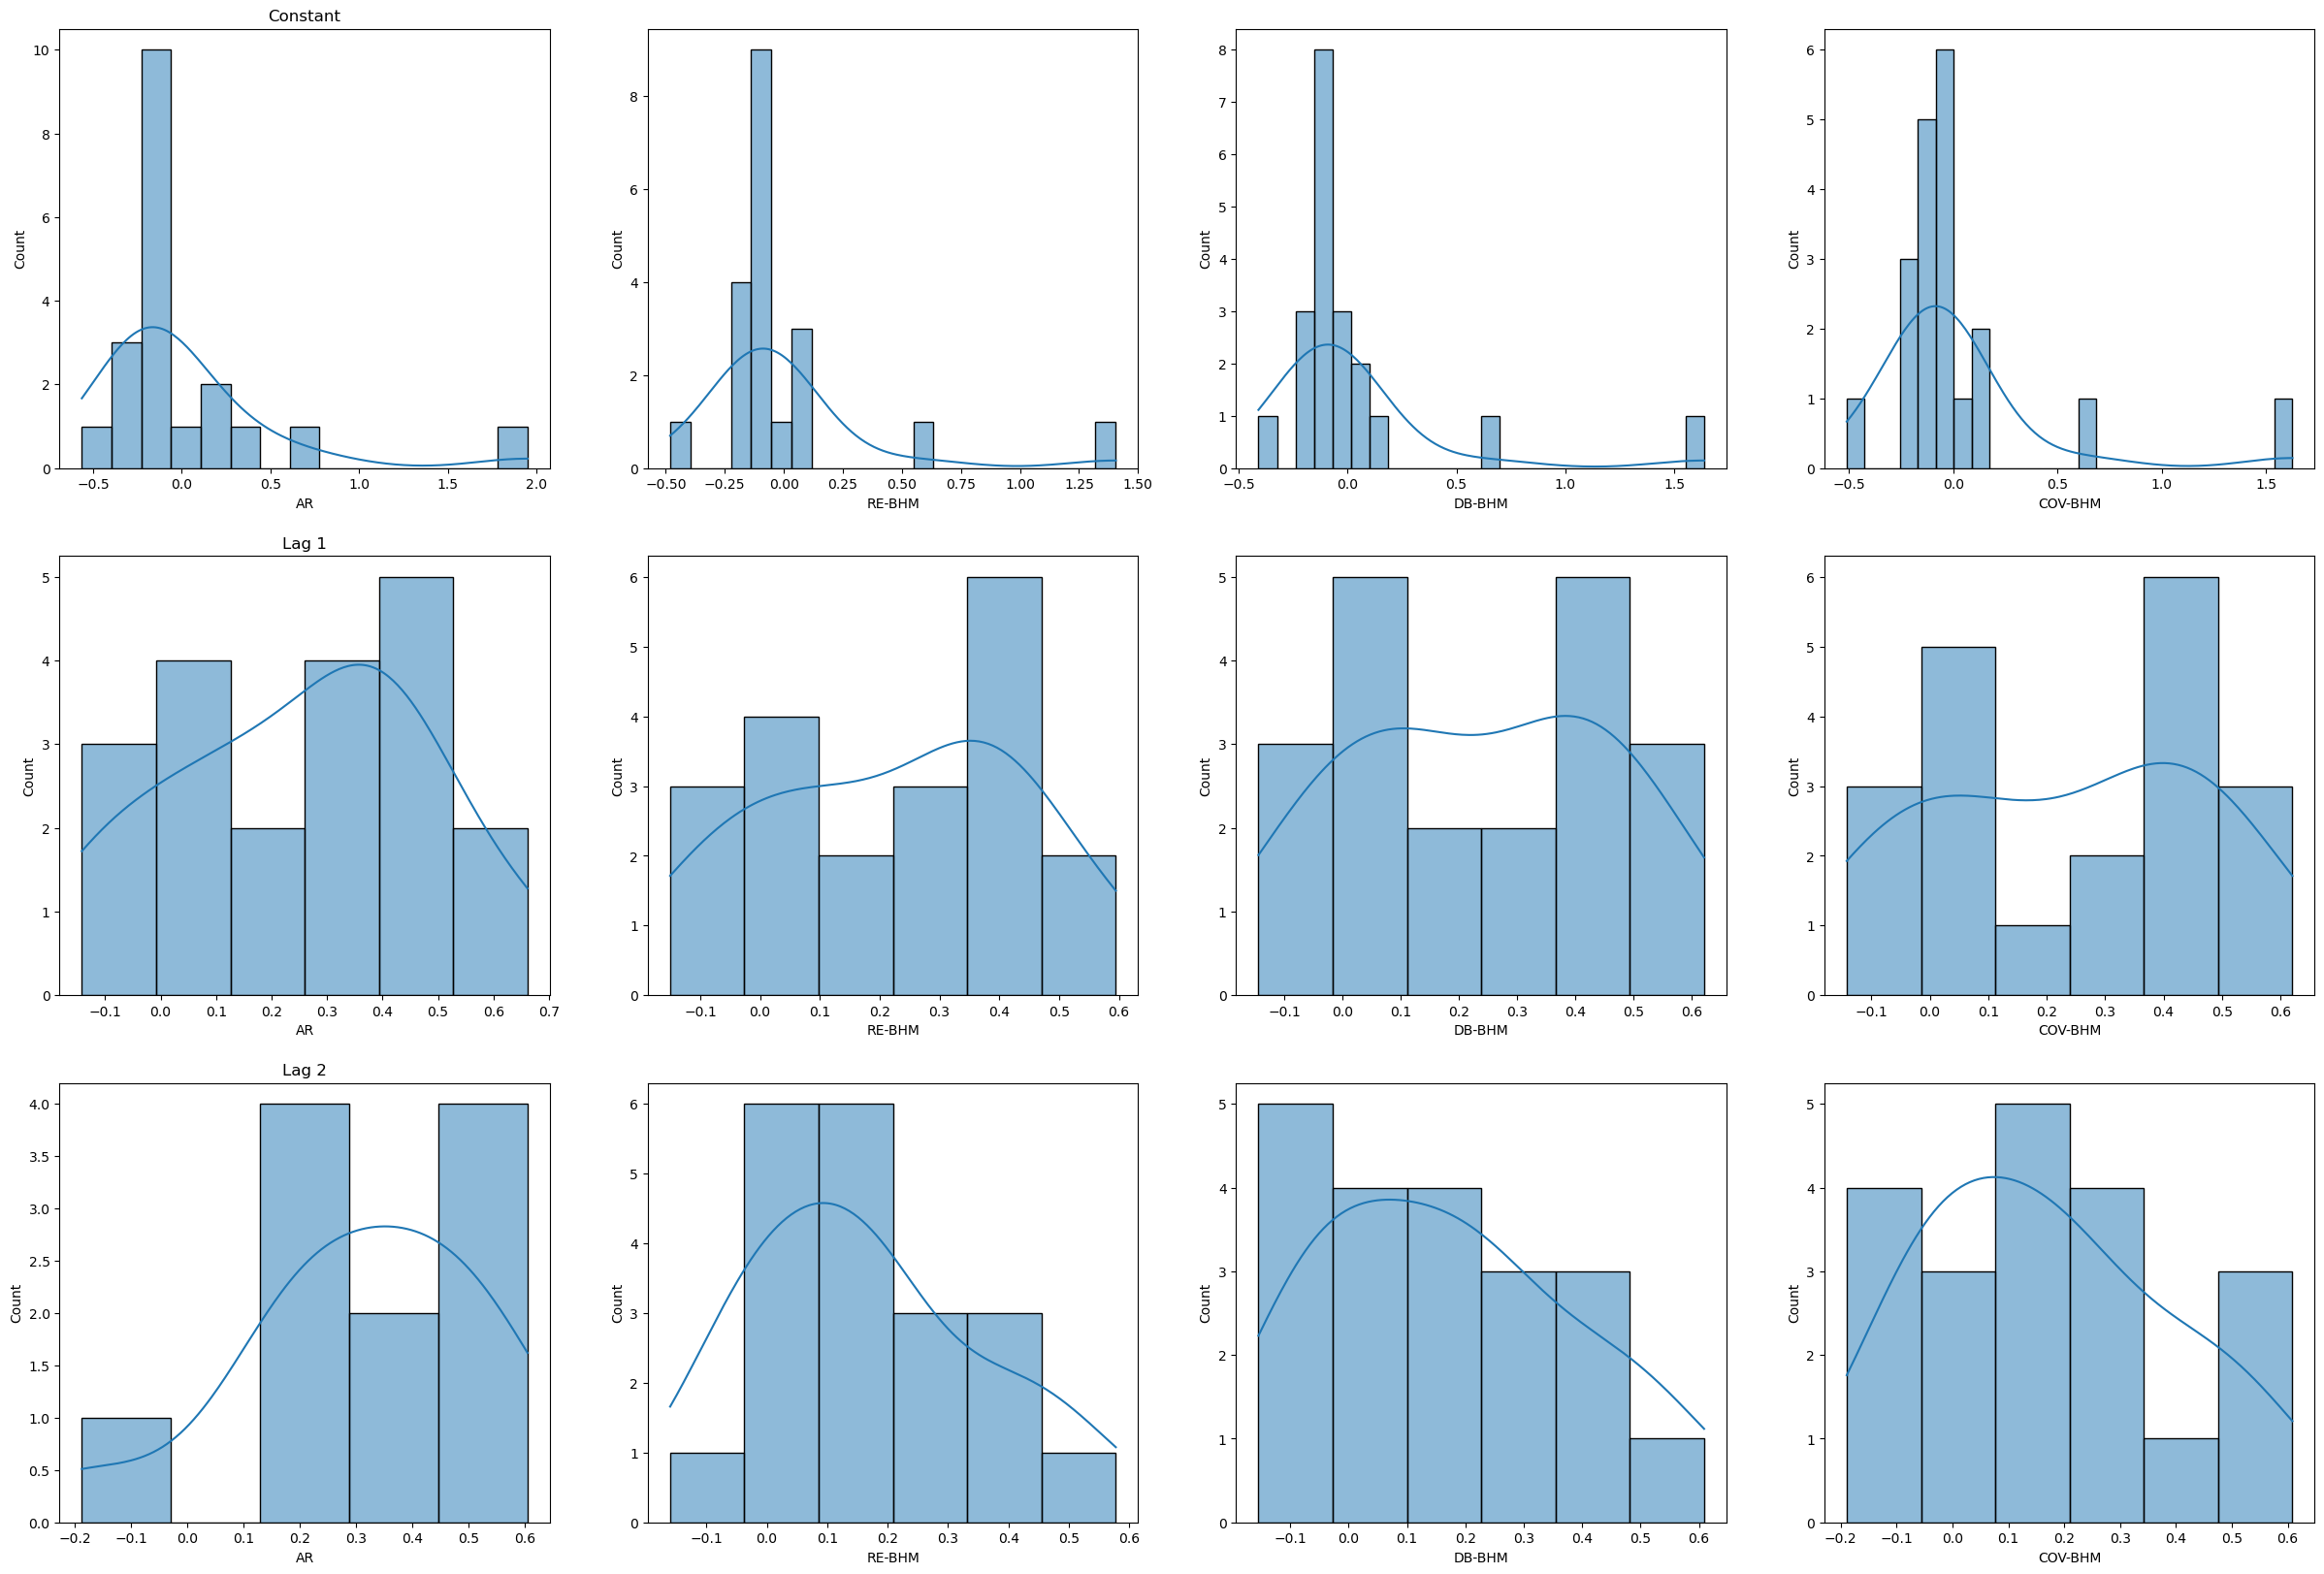

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
frame_use = params.reset_index()
const_frame = frame_use[frame_use["level_1"] == "const"]
L1_frame = frame_use[frame_use["level_1"] == "L1"]
L2_frame = frame_use[frame_use["level_1"] == "L2"]
figures, axes = plt.subplots(3,4, figsize=(30,20))
axes[0][0].set_title("Constant")
axes[1][0].set_title("Lag 1")
axes[2][0].set_title("Lag 2")
models = ["AR", "RE-BHM", "DB-BHM", "COV-BHM"]
for i in range(0,4):
    model = models[i]
    sns.histplot(
        data = const_frame[model],
        kde = True,
        ax = axes[0,i]
    )

for i in range(0,4):
    model = models[i]
    sns.histplot(
        data = L1_frame[model],
        kde = True,
        ax = axes[1,i]
    )
for i in range(0,4):
    model = models[i]
    sns.histplot(
        data = L2_frame[model],
        kde = True,
        ax = axes[2,i]
    )


<Axes: title={'center': 'Second Lag'}, ylabel='Count'>

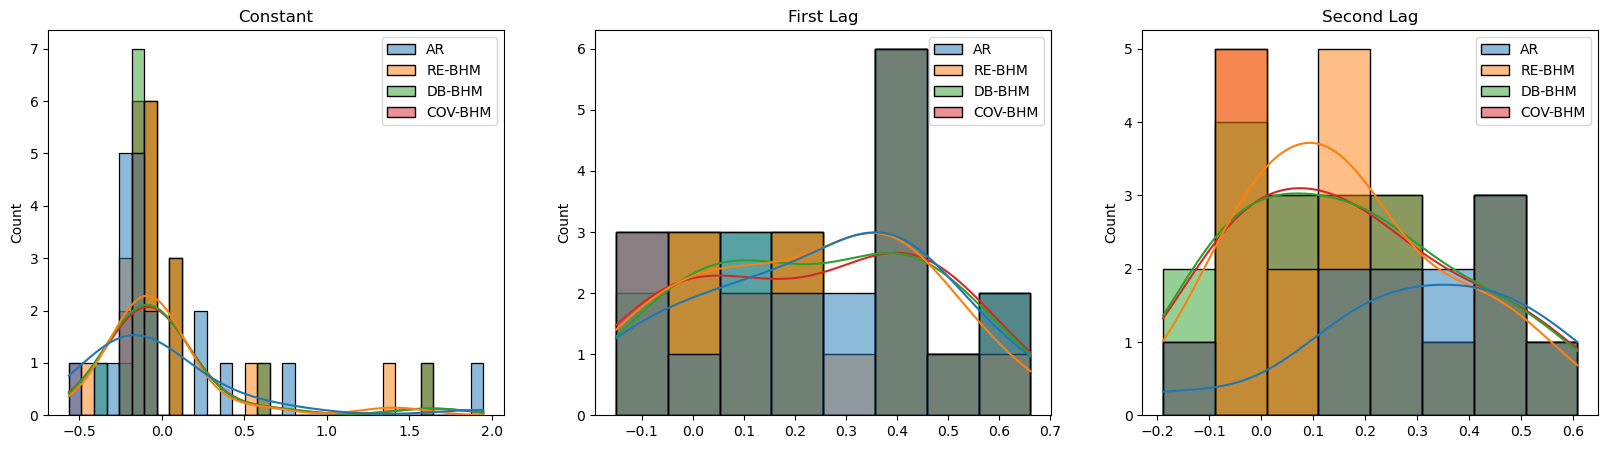

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
frame_use = params.reset_index()
const_frame = frame_use[frame_use["level_1"] == "const"]
L1_frame = frame_use[frame_use["level_1"] == "L1"]
L2_frame = frame_use[frame_use["level_1"] == "L2"]

figures, axis = plt.subplots(1,3,figsize=(20,5))
axis[0].set_title("Constant")
axis[1].set_title("First Lag")
axis[2].set_title("Second Lag")

sns.histplot(
    data = const_frame,
    kde = True,
    ax = axis[0],
)

sns.histplot(
    data=L1_frame,
    kde=True,
    ax= axis[1],
)

sns.histplot(
    data=L2_frame,
    kde=True,
    ax= axis[2]
)

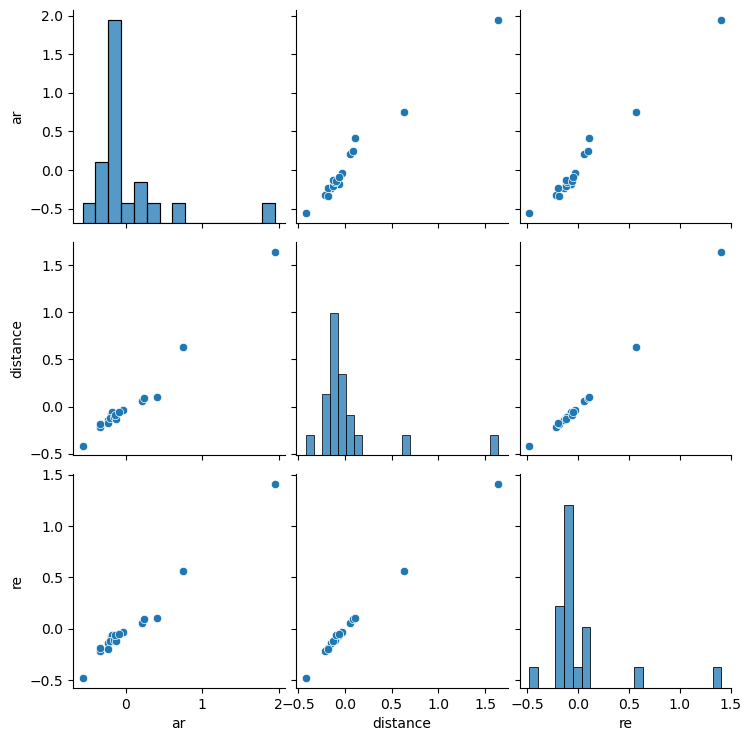

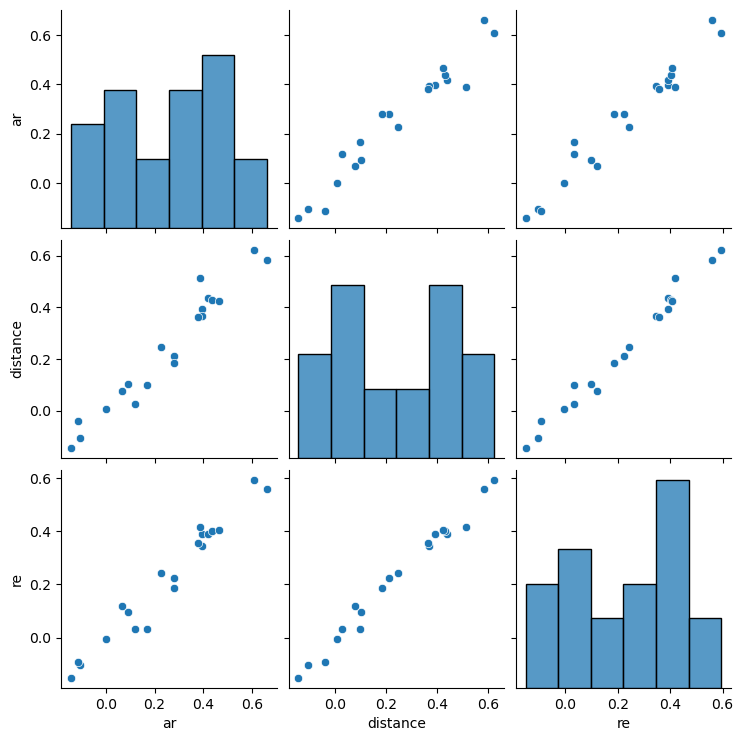

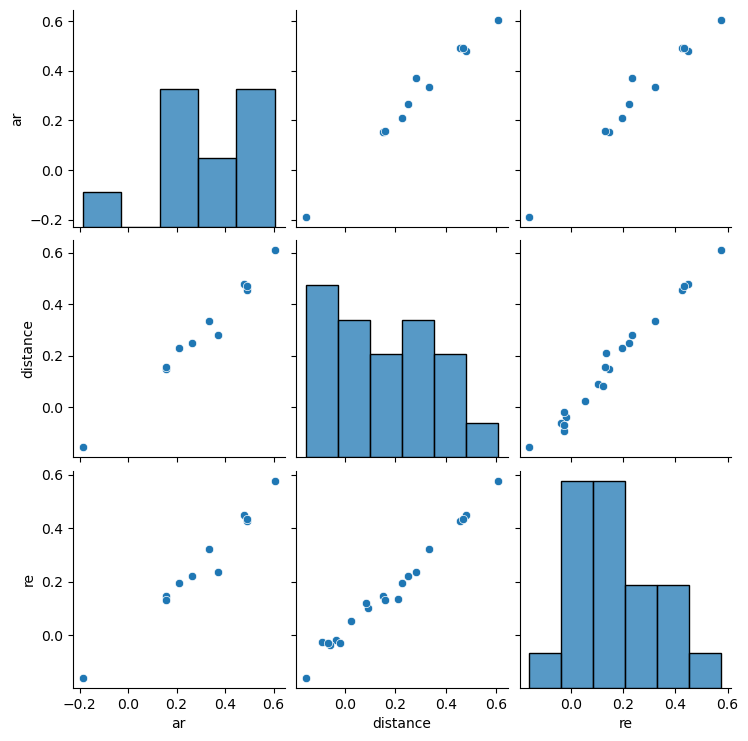

In [11]:
#note that mostly the ar constants are different from the other two models. 
#The lagged coefficients are very similar along models

from mpl_toolkits.mplot3d import Axes3D
sns.pairplot(const_frame[['ar','distance', 're']])
sns.pairplot(L1_frame[['ar','distance', 're']])
sns.pairplot(L2_frame[['ar','distance', 're']])

# Compare forecasts

pred_ar   pred_re  pred_distance
date       country                                         
2010-01-01 Japan         -0.000517  0.001779       0.001596
           Canada         0.004423  0.004230       0.004007
           United States  0.004770  0.007579       0.007475
           Australia      0.008212  0.008061       0.007950
           New Zealand    0.004304  0.008475       0.008586
...                            ...       ...            ...
2023-01-01 Norway         0.005842  0.005421       0.005439
           Belgium        0.017570  0.014052       0.013941
           Korea          0.006746  0.008612       0.009037
           South Africa   0.012052  0.016062       0.015024
2021-01-01 Türkiye        0.025702  0.024056       0.024228

[1060 rows x 3 columns]

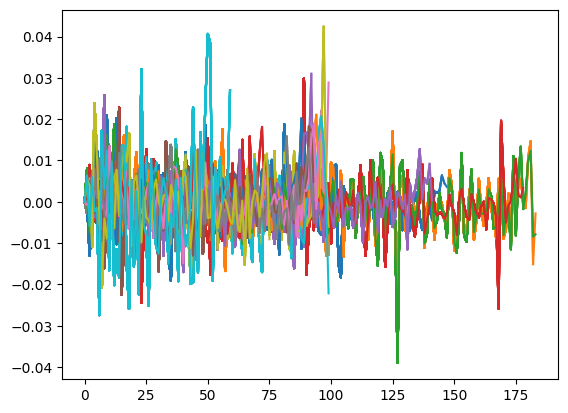

In [45]:
from seminartools.models.utils import h_period_ahead_forecast

preds = pd.concat(
    [
        h_period_ahead_forecast(
            model,
            df,
            h=1,
            start_date="2010-01-01",
        )
        .set_index(["date", "country"])["inflation"].rename(f"pred_{name}")
        #.rename(columns = {"inflation": f"pred_{name}"})
        for model, name in [
            (model_ar, "ar"),
            (model_re, "re"),
            (model_distance, "distance"),
        ]
    ], axis=1
)
preds

In [46]:
merged = preds.merge(df[["inflation", "date", "country"]], left_index=True, right_on = ["date", "country"]).set_index(["date", "country"]).dropna()
merged

pred_ar   pred_re  pred_distance  inflation
date       country                                                    
2010-01-01 Japan         -0.000517  0.001779       0.001596   0.000000
           Canada         0.004423  0.004230       0.004007   0.004405
           United States  0.004770  0.007579       0.007475   0.004014
           Australia      0.008212  0.008061       0.007950   0.009132
           New Zealand    0.004304  0.008475       0.008586   0.003659
...                            ...       ...            ...        ...
2023-01-01 Netherlands    0.002497  0.016483       0.017581  -0.013667
           Norway         0.005842  0.005421       0.005439   0.006886
           Belgium        0.017570  0.014052       0.013941  -0.003628
           Korea          0.006746  0.008612       0.009037   0.010538
           South Africa   0.012052  0.016062       0.015024   0.011202

[1016 rows x 4 columns]

In [49]:
from sklearn.metrics import mean_squared_error

for col in ["pred_ar", "pred_re", "pred_distance"]:
    print(f"{col}: {mean_squared_error(merged['inflation'], merged[col]):.2g}")

pred_ar: 4.9e-05
pred_re: 7.5e-05
pred_distance: 7.6e-05
